In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from util import convert_type
from eval import make_compare_plot,plot_cdf,plot_pdf,make_prediction_diff,make_prediction,DCR, hitting_rate, make_clustering
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import numpy
from tqdm import tqdm
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


In [2]:
data_full = pd.read_csv("dataset/train/adult.csv")

# 没用5%data

#data_sample = pd.read_csv("dataset/train/adult_train_sample.csv")

In [3]:
# * StrongNum : education-num + capical-gain -> hours-per-week
# * WeakNum: education-num -> age
# * Strong Cate: marital-status + sex -> relationshiop 
# * Weak Cate: education -> occupation


# ITS = origin loss + KL loss + fd loss + mean loss
# full = origin loss + KL loss + fd loss + mean loss + sel loss

strong_num_its = pd.read_csv("dataset/generated/strong_num/ITS/sample_data_1_981_0.csv")
weak_num_its = pd.read_csv("dataset/generated/weak_num/ITS/sample_data_1_982_0.csv")
strong_cate_its = pd.read_csv("dataset/generated/strong_cate/ITS/sample_data_1_983_0.csv")
weak_cate_its = pd.read_csv("dataset/generated/weak_cate/ITS/sample_data_1_984_0.csv")

strong_num_full = pd.read_csv("dataset/generated/strong_num/full/sample_data_1_980_0.csv")
weak_num_full = pd.read_csv("dataset/generated/weak_num/full/sample_data_1_980_0.csv")
strong_cate_full = pd.read_csv("dataset/generated/strong_cate/full/sample_data_1_980_0.csv")
weak_cate_full = pd.read_csv("dataset/generated/weak_cate/full/sample_data_1_980_0.csv")

In [4]:
# other baseline

# baseline_VAE = pd.read_csv("../VAE/expdir/adult/sample_data_vae_699_0.csv")
# baseline_VAE.columns = data.columns.tolist()

# baseline_tableGAN = pd.read_csv("generated/Adult_OI_11_00_fake.csv",sep=";")
# baseline_tableGAN_income = pd.read_csv("generated/tableGAN_income.csv")

# baseline_tableGAN["income"] = baseline_tableGAN_income
# baseline_tableGAN.columns=origin_GAN.columns

## Visualization

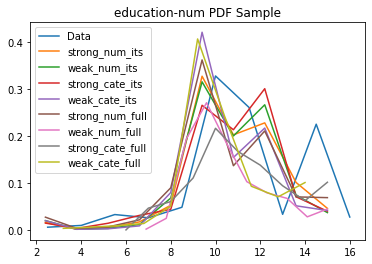

In [77]:
make_compare_plot([data_full,strong_num_its,weak_num_its,strong_cate_its,weak_cate_its,
strong_num_full,weak_num_full,strong_cate_full,weak_cate_full],"education-num",
plot_pdf,["Data","strong_num_its","weak_num_its","strong_cate_its","weak_cate_its",
"strong_num_full","weak_num_full","strong_cate_full","weak_cate_full"],"education-num PDF Sample")

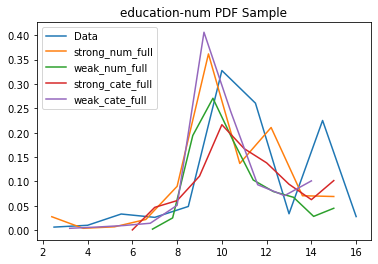

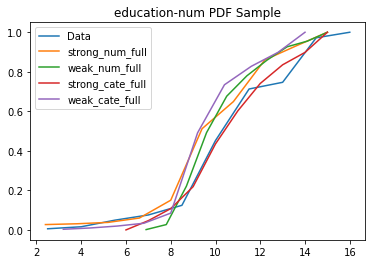

In [5]:
make_compare_plot([data_full,strong_num_full,weak_num_full,strong_cate_full,weak_cate_full],"education-num",
plot_pdf,["Data","strong_num_full","weak_num_full","strong_cate_full","weak_cate_full"],"education-num PDF Sample")
make_compare_plot([data_full,strong_num_full,weak_num_full,strong_cate_full,weak_cate_full],"education-num",
plot_cdf,["Data","strong_num_full","weak_num_full","strong_cate_full","weak_cate_full"],"education-num PDF Sample")

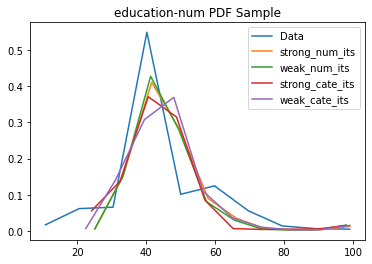

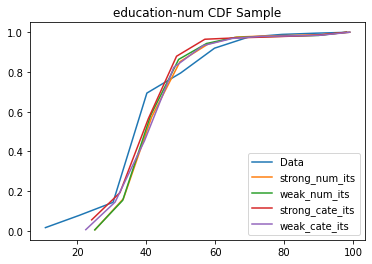

In [18]:
make_compare_plot([data_full,strong_num_its,weak_num_its,strong_cate_its,weak_cate_its],"hours-per-week",
plot_pdf,["Data","strong_num_its","weak_num_its","strong_cate_its","weak_cate_its"],"education-num PDF Sample")
make_compare_plot([data_full,strong_num_its,weak_num_its,strong_cate_its,weak_cate_its],"hours-per-week",
plot_cdf,["Data","strong_num_its","weak_num_its","strong_cate_its","weak_cate_its"],"education-num CDF Sample")

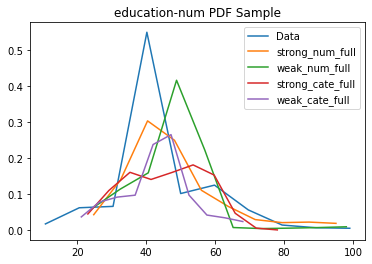

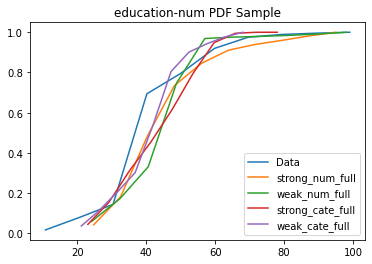

In [6]:
make_compare_plot([data_full,strong_num_full,weak_num_full,strong_cate_full,weak_cate_full],"hours-per-week",
plot_pdf,["Data","strong_num_full","weak_num_full","strong_cate_full","weak_cate_full"],"education-num PDF Sample")
make_compare_plot([data_full,strong_num_full,weak_num_full,strong_cate_full,weak_cate_full],"hours-per-week",
plot_cdf,["Data","strong_num_full","weak_num_full","strong_cate_full","weak_cate_full"],"education-num PDF Sample")


## Evaluation

#### Convert data type

In [8]:
data_full["label"] = "data"


strong_num_its["label"] = "strong_num_its"
weak_num_its["label"] = "weak_num_its"
strong_cate_its["label"] = "strong_cate_its"
weak_cate_its["label"] = "weak_cate_its"

strong_num_full["label"] = "strong_num_full"
weak_num_full["label"] = "weak_num_full"
strong_cate_full["label"] = "strong_cate_full"
weak_cate_full["label"] = "weak_cate_full"


# baseline_VAE["label"] = "VAE"
# baseline_tableGAN["label"] = "table"
# data_sample["label"] = "sample"

full = pd.concat([data_full,strong_num_its,weak_num_its,strong_cate_its,
weak_cate_its,strong_num_full,weak_num_full,strong_cate_full,weak_cate_full])
full[['workclass','education', 
       'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country','income']] = convert_type(full,['workclass','education', 
       'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country','income'])

data_full = full[full["label"] == "data"]


strong_num_its = full[full["label"] == "strong_num_its"]
weak_num_its = full[full["label"] == "weak_num_its"]
strong_cate_its = full[full["label"] == "strong_cate_its"]
weak_cate_its = full[full["label"] == "weak_cate_its"]

strong_num_full = full[full["label"] == "strong_num_full"]
weak_num_full = full[full["label"] == "weak_num_full"]
strong_cate_full = full[full["label"] == "strong_cate_full"]
weak_cate_full = full[full["label"] == "weak_cate_full"]


# baseline_VAE = full[full["label"] == "VAE"]
# baseline_table = full[full["label"] == "table"]

In [ ]:
# data["income"].to_csv("Adult_rule_modify_label.csv",index=False)
# data_sample.drop(columns=["label","income"]).astype("float64").to_csv("Adult_rule_modify.csv",index=False)

#### Split train and test

In [9]:
origin_np = np.array(data_full)
col = list(data_full.columns)
indices = numpy.random.permutation(data_full.shape[0])
n = int(data_full.shape[0] * 0.3)
test_idx, training_idx = indices[:n], indices[n:]
training_data, test = pd.DataFrame(origin_np[training_idx,:],columns = col), pd.DataFrame(origin_np[test_idx,:],columns = col)


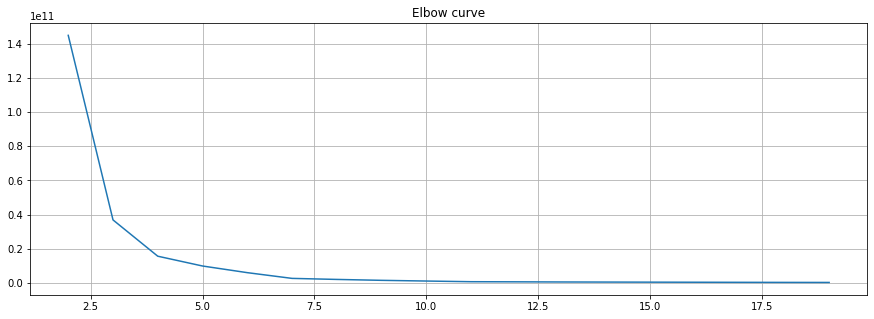

In [10]:
X = training_data.drop(columns=["label","fnlwgt"]).astype("float64")
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)

plt.title('Elbow curve')
plt.show()

In [28]:
dataset = [strong_num_its,weak_num_its,strong_cate_its,weak_cate_its,strong_num_full,weak_num_full,strong_cate_full,weak_cate_full]

In [29]:
prediction = {}
prediction["age"] = make_prediction("age", "reg",training_data, test,dataset)
prediction["workclass"] = make_prediction("workclass", "clf",training_data, test,dataset)
prediction["education"] = make_prediction("education", "clf",training_data, test,dataset)
prediction["education_num"] = make_prediction("education-num", "clf",training_data, test,dataset)
prediction["marital_status"] = make_prediction("marital-status", "clf",training_data, test,dataset)
prediction["occupation"] = make_prediction("occupation", "clf",training_data, test,dataset)
prediction["relationship"] = make_prediction("relationship", "clf",training_data, test,dataset)
prediction["race"] = make_prediction("race", "clf",training_data, test,dataset)
prediction["sex"] = make_prediction("sex", "clf",training_data, test,dataset)
prediction["capital_gain"] = make_prediction("capital-gain", "reg",training_data, test,dataset)
prediction["capital_loss"] = make_prediction("capital-loss", "reg",training_data, test,dataset)
prediction["hours_per_week"] = make_prediction("hours-per-week", "reg",training_data, test,dataset)
prediction["native_country"] = make_prediction("native-country", "clf",training_data, test,dataset)
prediction["income"] = make_prediction("income", "clf",training_data, test,dataset)

prediction_diff = {}
prediction_diff["age"] = make_prediction_diff("age", "reg",training_data, test,dataset)
prediction_diff["workclass"] = make_prediction_diff("workclass", "clf",training_data, test,dataset)
prediction_diff["education"] = make_prediction_diff("education", "clf",training_data, test,dataset)
prediction_diff["education_num"] = make_prediction_diff("education-num", "clf",training_data, test,dataset)
prediction_diff["marital_status"] = make_prediction_diff("marital-status", "clf",training_data, test,dataset)
prediction_diff["occupation"] = make_prediction_diff("occupation", "clf",training_data, test,dataset)
prediction_diff["relationship"] = make_prediction_diff("relationship", "clf",training_data, test,dataset)
prediction_diff["race"] = make_prediction_diff("race", "clf",training_data, test,dataset)
prediction_diff["sex"] = make_prediction_diff("sex", "clf",training_data, test,dataset)
prediction_diff["capital_gain"] = make_prediction_diff("capital-gain", "reg",training_data, test,dataset)
prediction_diff["capital_loss"] = make_prediction_diff("capital-loss", "reg",training_data, test,dataset)
prediction_diff["hours_per_week"] = make_prediction_diff("hours-per-week", "reg",training_data, test,dataset)
prediction_diff["native_country"] = make_prediction_diff("native-country", "clf",training_data, test,dataset)
prediction_diff["income"] = make_prediction_diff("income", "clf",training_data, test,dataset)

### Machine Learning utils

* StrongNum : education-num + capical-gain -> hours-per-week
* WeakNum: education-num -> age
* Strong Cate: marital-status + sex -> relationshiop 
* Weak Cate: education -> occupation

In [31]:
pd.DataFrame(prediction,index=["ground Truth","Strong-Num_its","Weak-Num_its","Strong-Cate_its","Weak-Cate_its",
                                "Strong-Num_full","Weak-Num_full","Strong-Cate_full","Weak-Cate_full"])

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
ground Truth,0.441439,0.749668,1.000000,1.000000,0.848187,0.341552,0.794560,0.878372,0.851393,0.002208,-0.058440,0.224740,0.917514,0.862340
Strong-Num_its,-0.148356,0.735958,0.402587,0.272114,0.715834,0.181004,0.522004,0.823861,0.734299,-4.201787,-0.140933,-0.636687,0.777311,0.758072
Weak-Num_its,-0.164577,0.730097,0.403914,0.245245,0.694494,0.165966,0.545002,0.830716,0.743919,-3.527250,-0.086410,-0.372737,0.861676,0.761499
Strong-Cate_its,-0.448149,0.381911,0.386444,0.139319,0.686201,0.155904,0.588346,0.754091,0.696594,-7.304176,-1.370118,-0.360151,0.273220,0.734410
Weak-Cate_its,-0.203057,0.731756,0.360239,0.325520,0.675254,0.157342,0.538257,0.842326,0.714949,-2.743135,-0.409130,-0.543757,0.841884,0.763490
Strong-Num_full,-0.103512,0.658558,0.361455,0.220146,0.629368,0.117868,0.478660,0.823972,0.593100,-1.856182,-1.510830,-0.368883,0.661101,0.758072
Weak-Num_full,-0.260018,0.685759,0.405904,0.300752,0.645953,0.161986,0.567559,0.803184,0.664197,-6.559870,-2.225467,-0.176393,0.894626,0.774326
Strong-Cate_full,-0.179859,0.680893,0.366099,0.217492,0.701238,0.184100,0.563467,0.846970,0.677023,-1.865590,-1.638358,-0.302266,0.889651,0.755971
Weak-Cate_full,-0.133237,0.635338,0.330606,0.073198,0.501216,0.192393,0.474126,0.751990,0.723352,-6.021504,-3.452071,-0.344058,0.868421,0.767249


In [32]:
pd.DataFrame(prediction_diff,index=["ground Truth","Strong-Num_its","Weak-Num_its","Strong-Cate_its","Weak-Cate_its",
                                "Strong-Num_full","Weak-Num_full","Strong-Cate_full","Weak-Cate_full"])

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
ground Truth,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Strong-Num_its,0.589795,0.013711,0.597413,0.727886,0.132353,0.160548,0.272556,0.054511,0.117094,4.203995,0.082493,0.861427,0.140203,0.104268
Weak-Num_its,0.606015,0.019571,0.596086,0.754755,0.153693,0.175586,0.249558,0.047656,0.107475,3.529457,0.027970,0.597477,0.055838,0.100840
Strong-Cate_its,0.889588,0.367758,0.613556,0.860681,0.161986,0.185648,0.206214,0.124281,0.154799,7.306384,1.311677,0.584891,0.644295,0.127930
Weak-Cate_its,0.644496,0.017912,0.639761,0.674480,0.172932,0.184211,0.256303,0.036046,0.136444,2.745343,0.350690,0.768497,0.075630,0.098850
Strong-Num_full,0.544950,0.091110,0.638545,0.779854,0.218819,0.223684,0.315900,0.054401,0.258293,1.858390,1.452390,0.593623,0.256413,0.104268
Weak-Num_full,0.701457,0.063910,0.594096,0.699248,0.202234,0.179567,0.227001,0.075188,0.187196,6.562078,2.167027,0.401133,0.022888,0.088014
Strong-Cate_full,0.621298,0.068775,0.633901,0.782508,0.146948,0.157452,0.231092,0.031402,0.174370,1.867798,1.579917,0.527005,0.027864,0.106369
Weak-Cate_full,0.574675,0.114330,0.669394,0.926802,0.346970,0.149160,0.320433,0.126382,0.128041,6.023711,3.393631,0.568798,0.049093,0.095091


its:7 col
full:7 col

### Clustering

In [14]:
from sklearn.cluster import KMeans
pd.DataFrame(make_clustering(training_data,test,dataset),index=["ground Truth","Strong-Num_its","Weak-Num_its","Strong-Cate_its","Weak-Cate_its",
                                "Strong-Num_full","Weak-Num_full","Strong-Cate_full","Weak-Cate_full"],columns=["Clustering NMI"])

,Clustering NMI
ground Truth,1.000000
Strong-Num_its,0.566436
Weak-Num_its,0.507384
Strong-Cate_its,0.507384
Weak-Cate_its,0.566436
Strong-Num_full,0.558096
Weak-Num_full,0.507384
Strong-Cate_full,0.507384
Weak-Cate_full,0.558096


## Loss 

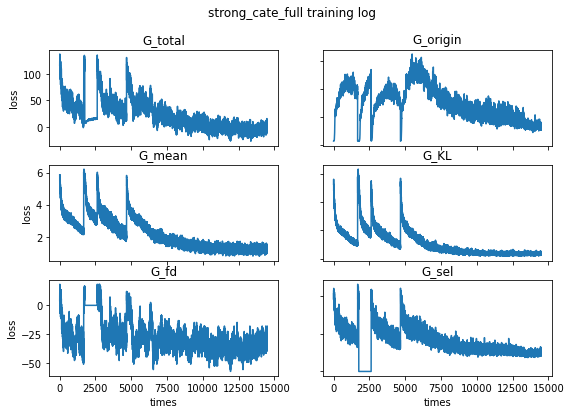

In [93]:
data_log = pd.read_csv("dataset/generated/strong_cate/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_cate_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

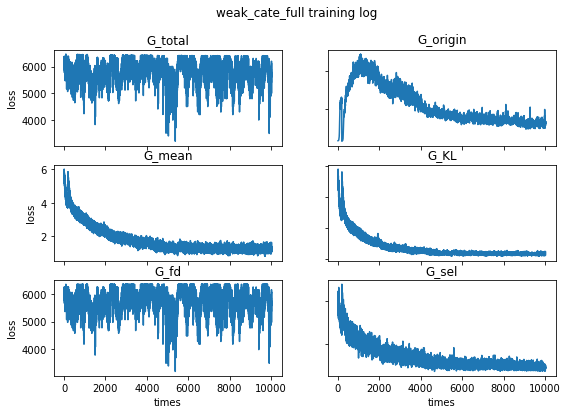

In [94]:
data_log = pd.read_csv("dataset/generated/weak_cate/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_cate_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

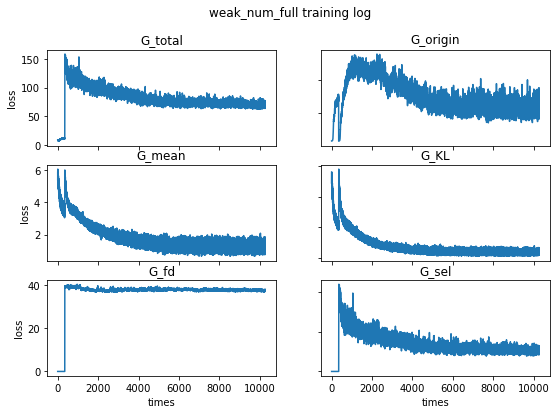

In [95]:
data_log = pd.read_csv("dataset/generated/weak_num/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_num_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

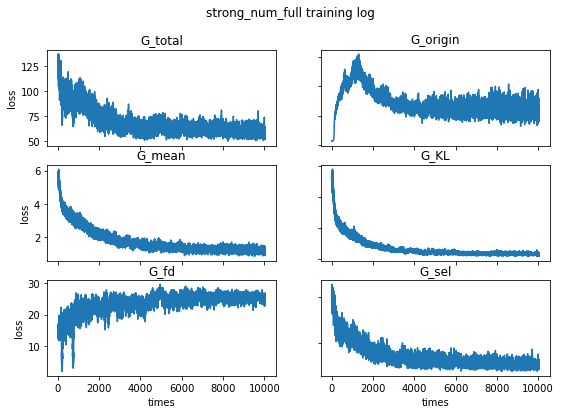

In [96]:
data_log = pd.read_csv("dataset/generated/strong_num/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_num_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

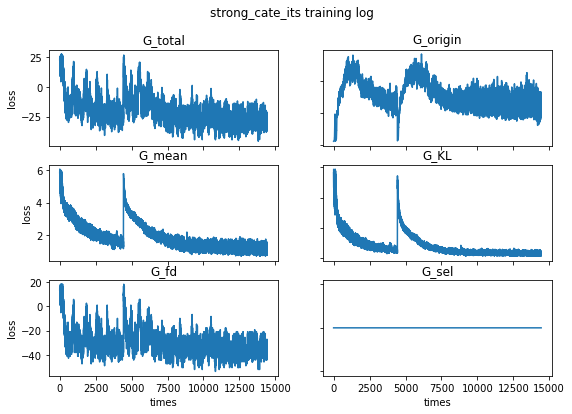

In [97]:
data_log = pd.read_csv("dataset/generated/strong_cate/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_cate_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

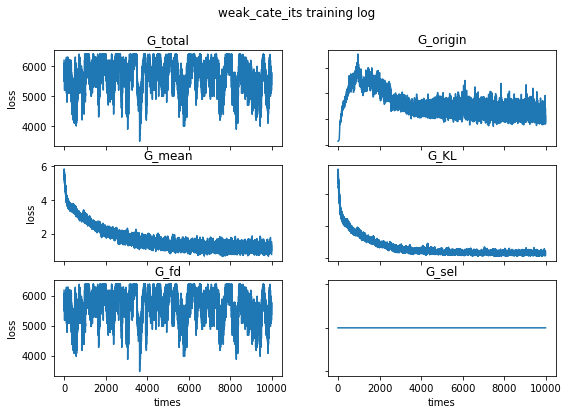

In [98]:
data_log = pd.read_csv("dataset/generated/weak_cate/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_cate_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

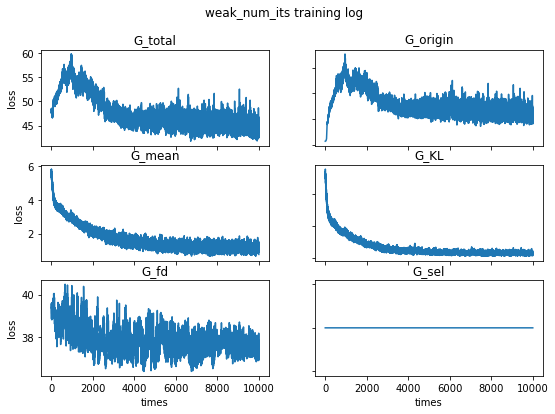

In [99]:
data_log = pd.read_csv("dataset/generated/weak_num/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_num_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

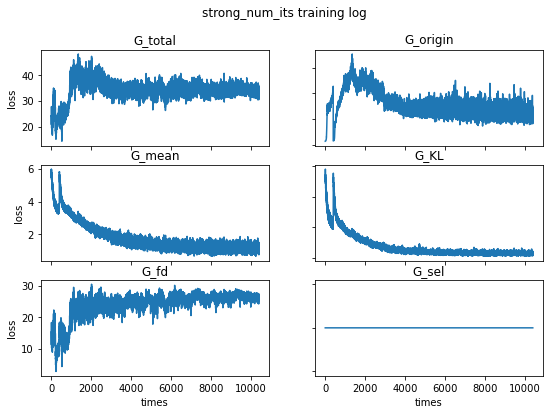

In [100]:
data_log = pd.read_csv("dataset/generated/strong_num/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_num_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

### Approximate query processing (AQP)

AQP 
* http://dbgroup.cs.tsinghua.edu.cn/ligl/baq.pdf 
* https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9101822


### Privacy protection

#### Hitting Rate & DCR

In [22]:
len(dataset)

8

[471, 107, 358, 23, 40, 36, 17]

In [15]:
similar = hitting_rate(dataset)

500it [01:47,  4.65it/s]
500it [11:03,  1.33s/it]
500it [04:58,  1.68it/s]
500it [13:06,  1.57s/it]
500it [12:43,  1.53s/it]
500it [12:52,  1.54s/it]
500it [13:19,  1.60s/it]


In [16]:
maxi,mini = DCR(dataset)


In [ ]:
pd.DataFrame(np.array([similar,maxi,mini]).T,index=["Origin GAN","Strong-Num_its","Weak-Num_its","Strong-Cate_its","Weak-Cate_its","Strong-Num_full","Weak-Num_full","Strong-Cate_full","Weak-Cate_full"],columns=["Exactly Same data (Categorical)","Distance to the furthest record","Distance to the closest record"])